In [3]:
pip install mediapipe==0.10.9 opencv-python==4.7.0.72 moviepy librosa pandas numpy==1.26.4 scikit-learn matplotlib tqdm soundfile


Note: you may need to restart the kernel to use updated packages.


Imports + Device Check

In [11]:
import torch
import cv2
import librosa
import numpy as np
import pandas as pd

import moviepy          # top-level moviepy package
from moviepy import VideoFileClip

import mediapipe as mp
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

print("Packages imported successfully")

print("\nPython executable:", __import__("sys").executable)

# Torch / GPU info
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Library versions
print("\nOpenCV version:", cv2.__version__)
print("Librosa version:", librosa.__version__)
print("MoviePy version:", moviepy.__version__)
print("Mediapipe version:", mp.__version__)


Packages imported successfully

Python executable: D:\Software\Anaconda3\envs\deepfake\python.exe
Torch version: 2.5.1
CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU

OpenCV version: 4.11.0
Librosa version: 0.11.0
MoviePy version: 2.1.2
Mediapipe version: 0.10.9


Load CSV + Build Paths + Labels + Split

In [3]:
import os
import pandas as pd

# Project and data locations
PROJECT_ROOT = os.getcwd()
DATA_ROOT = os.path.join(PROJECT_ROOT, "FakeAVCeleb_v1.2") 
META_PATH = os.path.join(DATA_ROOT, "meta_data.csv")

print("Current working directory:", PROJECT_ROOT)
print("Expected meta_data.csv path:", META_PATH)
print("meta_data.csv exists:", os.path.exists(META_PATH))

# Load CSV
df = pd.read_csv(META_PATH)
print("\nColumns:", df.columns)

print("\nFirst 3 rows of 'path' and 'Unnamed: 9':")
print(df[["path", "Unnamed: 9"]].head(3))


Current working directory: D:\Jaypee\SEM\Major_Main
Expected meta_data.csv path: D:\Jaypee\SEM\Major_Main\FakeAVCeleb_v1.2\meta_data.csv
meta_data.csv exists: True

Columns: Index(['source', 'target1', 'target2', 'method', 'category', 'type', 'race',
       'gender', 'path', 'Unnamed: 9'],
      dtype='object')

First 3 rows of 'path' and 'Unnamed: 9':
        path                                         Unnamed: 9
0  00109.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...
1  00010.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...
2  00118.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...


In [4]:
import os
import pandas as pd

# 1) Paths
PROJECT_ROOT = os.getcwd()
DATA_ROOT = os.path.join(PROJECT_ROOT, "FakeAVCeleb_v1.2")
META_PATH = os.path.join(DATA_ROOT, "meta_data.csv")

print("Current working directory:", PROJECT_ROOT)
print("meta_data.csv path:", META_PATH)
print("meta_data.csv exists:", os.path.exists(META_PATH))

# 2) Load CSV fresh
df = pd.read_csv(META_PATH)
print("\nColumns:", df.columns)

print("\nSample of 'path' and 'Unnamed: 9':")
print(df[["path", "Unnamed: 9"]].head(5))

# 3) Build correct full video path
def build_full_path(row):
    # Example Unnamed: 9:  FakeAVCeleb/RealVideo-RealAudio/African/men/id00076
    folder_rel = str(row["Unnamed: 9"]).strip("\\/")

    # Replace leading 'FakeAVCeleb' with 'FakeAVCeleb_v1.2'
    if folder_rel.startswith("FakeAVCeleb"):
        folder_rel = folder_rel.replace("FakeAVCeleb", "FakeAVCeleb_v1.2", 1)

    filename = str(row["path"]).strip("\\/")
    return os.path.join(PROJECT_ROOT, folder_rel, filename)

df["video_path"] = df.apply(build_full_path, axis=1)

print("\nSample video_path values with existence check:")
for p in df["video_path"].head(5):
    print(" ", p, " | exists:", os.path.exists(p))

# 4) Create 4-class label from folder name
def label_from_path(p):
    if "RealVideo-RealAudio" in p:
        return 0
    if "FakeVideo-RealAudio" in p:
        return 1
    if "RealVideo-FakeAudio" in p:
        return 2
    if "FakeVideo-FakeAudio" in p:
        return 3
    return -1

df["label"] = df["video_path"].apply(label_from_path)
df = df[df["label"] >= 0].reset_index(drop=True)

# 5) Create train/val/test split if not present
if "split" not in df.columns:
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    n = len(df)
    df.loc[:int(0.8*n), "split"] = "train"
    df.loc[int(0.8*n):int(0.9*n), "split"] = "val"
    df.loc[int(0.9*n):, "split"] = "test"

print("\nSplit counts:")
print(df["split"].value_counts())

print("\nHead:")
df[["video_path", "label", "split"]].head()


Current working directory: D:\Jaypee\SEM\Major_Main
meta_data.csv path: D:\Jaypee\SEM\Major_Main\FakeAVCeleb_v1.2\meta_data.csv
meta_data.csv exists: True

Columns: Index(['source', 'target1', 'target2', 'method', 'category', 'type', 'race',
       'gender', 'path', 'Unnamed: 9'],
      dtype='object')

Sample of 'path' and 'Unnamed: 9':
        path                                         Unnamed: 9
0  00109.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...
1  00010.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...
2  00118.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...
3  00118.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...
4  00052.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...

Sample video_path values with existence check:
  D:\Jaypee\SEM\Major_Main\FakeAVCeleb_v1.2/RealVideo-RealAudio/African/men/id00076\00109.mp4  | exists: True
  D:\Jaypee\SEM\Major_Main\FakeAVCeleb_v1.2/RealVideo-RealAudio/African/men/id00166\00010.mp4  | exists: True
  D:\Jay

,video_path,label,split
0,D:\Jaypee\SEM\Major_Main\FakeAVCeleb_v1.2/Fake...,1,train
1,D:\Jaypee\SEM\Major_Main\FakeAVCeleb_v1.2/Fake...,1,train
2,D:\Jaypee\SEM\Major_Main\FakeAVCeleb_v1.2/Fake...,1,train
3,D:\Jaypee\SEM\Major_Main\FakeAVCeleb_v1.2/Fake...,3,train
4,D:\Jaypee\SEM\Major_Main\FakeAVCeleb_v1.2/Fake...,1,train


Audio Feature Extraction

Sample video for audio visualization:
D:\Jaypee\SEM\Major_Main\FakeAVCeleb_v1.2/FakeVideo-RealAudio/African/women/id02617\00028_id05252_CMxIX3absYM.mp4
Audio diagnostics:
  samples: (146432,)
  duration (s): 9.152
  min, max, mean, std: -0.278900146484375 0.28045654296875 2.2635176719632e-05 0.04542628303170204


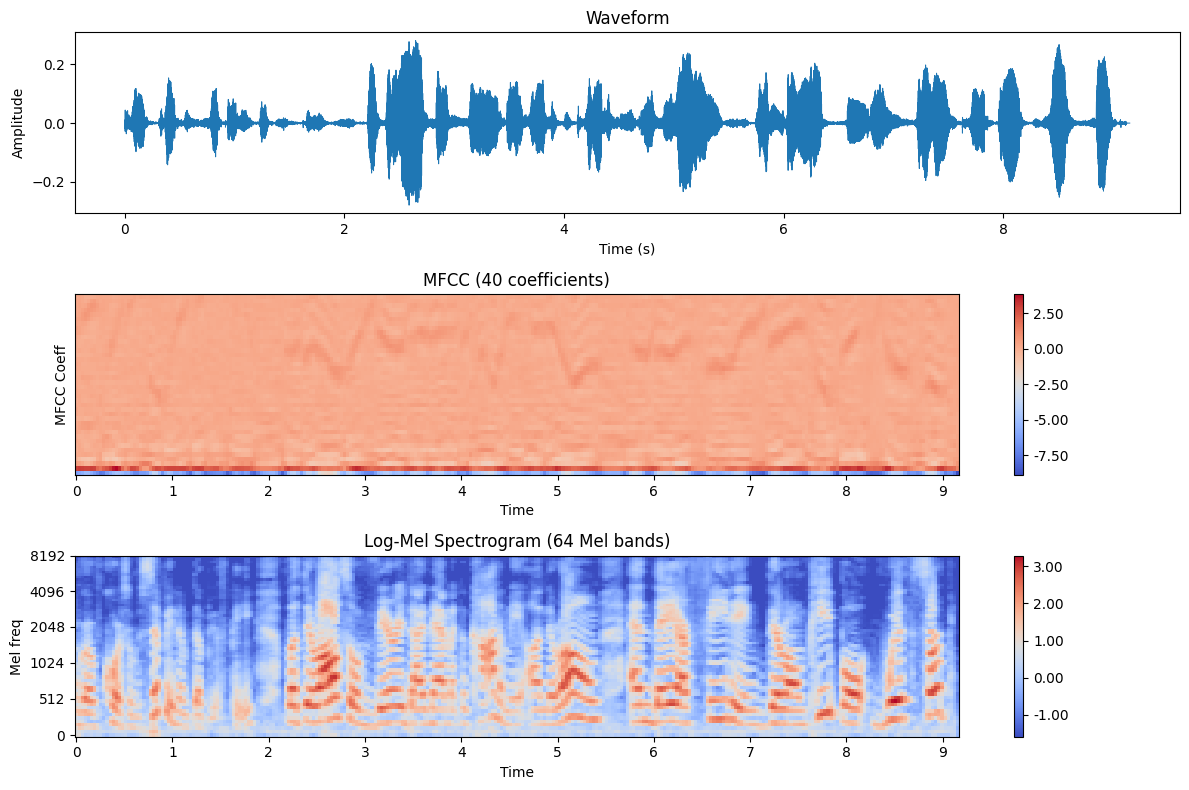

In [7]:
import os
import subprocess
import tempfile
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
# AUDIO_SR = 16000
# N_MFCC = 40
# N_MELS = 64

def load_audio_from_video(video_path, sr=AUDIO_SR, ffmpeg_cmd="ffmpeg"):
    """
    Extract audio from video using ffmpeg into a temporary WAV and load it.
    Returns a 1D float32 numpy array (mono) or None on failure.
    """
    if not os.path.exists(video_path):
        print("Video path does not exist:", video_path)
        return None

    tmp_wav = None
    try:
        tmp_wav = tempfile.mktemp(suffix=".wav")
        cmd = [
            ffmpeg_cmd,
            "-y",                 # overwrite
            "-i", video_path,     # input
            "-vn",                # no video
            "-ac", "1",           # mono audio
            "-ar", str(sr),       # output sampling rate
            "-f", "wav",
            tmp_wav
        ]
        # run ffmpeg, capture stderr to show useful messages on failure
        res = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        if res.returncode != 0:
            stderr = res.stderr.decode(errors="ignore")
            print("ffmpeg failed to extract audio. ffmpeg stderr:")
            print(stderr.splitlines()[:20])  # print first few lines for brevity
            return None

        # load audio with librosa (handles resampling if necessary)
        y, file_sr = librosa.load(tmp_wav, sr=sr, mono=True)
        y = y.astype(np.float32)
        return y

    except FileNotFoundError:
        print("ffmpeg executable not found. Install ffmpeg and ensure it's on your PATH.")
        return None
    except Exception as e:
        print("Error extracting/loading audio:", e)
        return None
    finally:
        try:
            if tmp_wav and os.path.exists(tmp_wav):
                os.remove(tmp_wav)
        except Exception:
            pass

# extract_audio_features expects raw waveform and returns (mfcc, log_mel),
def extract_audio_features_safe(y, sr=AUDIO_SR, n_mfcc=N_MFCC, n_mels=N_MELS, hop_length=512):
    """
    If your original extract_audio_features exists, keep using it.
    This function is a fallback that computes MFCC and log-mel spectrogram.
    """
    # ensure float32
    y = y.astype(np.float32)
    # Mel spectrogram (power)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length, power=2.0)
    log_mel = librosa.power_to_db(mel_spec, ref=np.max)
    # MFCC: compute from mel_spec (works consistently)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel_spec), n_mfcc=n_mfcc)
    return mfcc, log_mel

# Choose a sample video path from your dataframe (same as before)
sample_path = df["video_path"].iloc[0]
print("Sample video for audio visualization:")
print(sample_path)

# Load audio
y = load_audio_from_video(sample_path)
if y is None:
    print("Could not load audio.")
else:
    print("Audio diagnostics:")
    print("  samples:", y.shape)
    print("  duration (s):", len(y) / AUDIO_SR)
    print("  min, max, mean, std:", float(y.min()), float(y.max()), float(y.mean()), float(y.std()))
    if np.allclose(y, 0.0, atol=1e-8):
        print("Warning: audio appears silent (all zeros).")

    # Extract features
    try:
        # use the notebook's extract_audio_features
        mfcc, log_mel = extract_audio_features(y)
    except Exception:
        # fallback to the safe extractor above
        mfcc, log_mel = extract_audio_features_safe(y, sr=AUDIO_SR)

    # Time axis for waveform (in seconds)
    sr = AUDIO_SR
    t = np.linspace(0, len(y) / sr, num=len(y))

    # Plot 
    plt.figure(figsize=(12, 8))
    # (a) Waveform
    plt.subplot(3, 1, 1)
    plt.plot(t, y, linewidth=0.7)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # (b) MFCC as image (ensure mfcc shape is [n_mfcc, time_frames])
    plt.subplot(3, 1, 2)
    # if mfcc has shape (time, n) transpose it
    if mfcc.shape[0] < mfcc.shape[1] and mfcc.shape[0] != N_MFCC:
        # attempt to detect transposed shape and correct it
        mfcc = mfcc.T
    librosa.display.specshow(mfcc, x_axis="time", sr=sr, hop_length=512)
    plt.title(f"MFCC ({mfcc.shape[0]} coefficients)")
    plt.colorbar(format="%.2f")
    plt.ylabel("MFCC Coeff")

    # (c) Log-Mel spectrogram as image
    plt.subplot(3, 1, 3)
    # log_mel shape should be (n_mels, time_frames)
    if log_mel.ndim == 2:
        librosa.display.specshow(log_mel, x_axis="time", y_axis="mel", sr=sr, hop_length=512)
    else:
        # if somehow incorrect dimension, convert to 2d before showing
        librosa.display.specshow(np.atleast_2d(log_mel), x_axis="time", y_axis="mel", sr=sr, hop_length=512)
    plt.title(f"Log-Mel Spectrogram ({log_mel.shape[0]} Mel bands)")
    plt.colorbar(format="%.2f")
    plt.ylabel("Mel freq")

    plt.tight_layout()
    plt.show()


Lip Detection + Frame Extraction

Testing video pipeline on: D:\Jaypee\SEM\Major_Main\FakeAVCeleb_v1.2/FakeVideo-RealAudio/African/women/id02617\00028_id05252_CMxIX3absYM.mp4
Frames array shape: (16, 3, 112, 112)


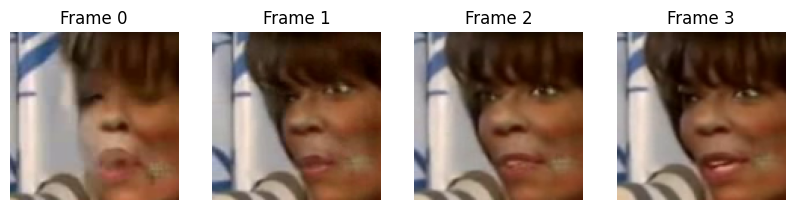

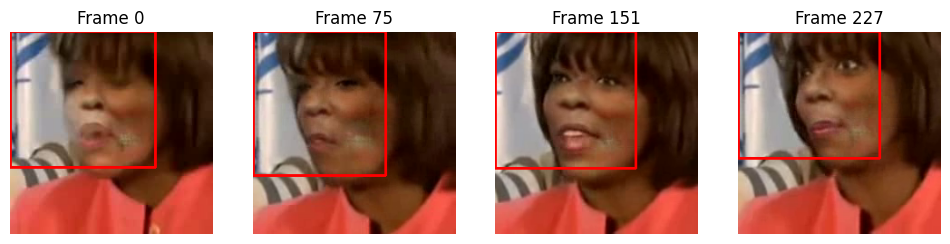

In [20]:
import cv2
import numpy as np
import mediapipe as mp

# Number of frames to sample per video and input size
NUM_FRAMES = 16
IMG_SIZE = 112

# Initialize MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
)
# Lip landmark indices according to MediaPipe FaceMesh
LIP_LANDMARKS = list(range(61, 88))

def get_lip_bbox(landmarks, image_w, image_h, margin=0.3):
    """
    Compute a square bounding box around lip landmarks.
    Returns (x1, y1, x2, y2) in pixel coordinates.
    """
    xs = [landmarks[i].x for i in LIP_LANDMARKS]
    ys = [landmarks[i].y for i in LIP_LANDMARKS]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    cx = (min_x + max_x) / 2
    cy = (min_y + max_y) / 2
    side = max(max_x - min_x, max_y - min_y) * (1 + margin)
    x1 = max(0, int((cx - side / 2) * image_w))
    x2 = min(image_w, int((cx + side / 2) * image_w))
    y1 = max(0, int((cy - side / 2) * image_h))
    y2 = min(image_h, int((cy + side / 2) * image_h))

    return x1, y1, x2, y2


def extract_lip_frames(video_path, num_frames=NUM_FRAMES):
    """
    Extract num_frames lip crops from a video.
    Returns a numpy array of shape (T, 3, IMG_SIZE, IMG_SIZE) in [0,1] or None on error.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Video open error:", video_path)
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        print("No frames in video:", video_path)
        cap.release()
        return None

    # Choose evenly spaced frame indices
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []

    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ret, frame = cap.read()
        if not ret:
            continue

        h, w = frame.shape[:2]
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = mp_face_mesh.process(rgb)

        # If face detected, crop around lips; else use full frame
        if results.multi_face_landmarks:
            lm = results.multi_face_landmarks[0].landmark
            x1, y1, x2, y2 = get_lip_bbox(lm, w, h)
            crop = frame[y1:y2, x1:x2]
        else:
            crop = frame

        crop = cv2.resize(crop, (IMG_SIZE, IMG_SIZE))
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        crop = crop.astype(np.float32) / 255.0
        crop = np.transpose(crop, (2, 0, 1))  # (3, H, W)

        frames.append(crop)

    cap.release()

    if len(frames) == 0:
        print("No frames extracted for:", video_path)
        return None

    frames = np.stack(frames, axis=0)  # (T, 3, H, W)
    return frames.astype(np.float32)


# Quick test sample video used for audio
sample_path = df["video_path"].iloc[0]
print("Testing video pipeline on:", sample_path)

frames = extract_lip_frames(sample_path)
if frames is None:
    print("Failed to extract frames.")
else:
    print("Frames array shape:", frames.shape)


import matplotlib.pyplot as plt

# Display frames 
if frames is not None:
    num_show = min(4, frames.shape[0])  # show first 4 frames
    plt.figure(figsize=(10, 3))
    for i in range(num_show):
        img = frames[i].transpose(1, 2, 0)  # convert back to HWC
        plt.subplot(1, num_show, i+1)
        plt.imshow(img)
        plt.title(f"Frame {i}")
        plt.axis('off')
    plt.show()

import matplotlib.pyplot as plt
import cv2

def show_lip_boxes(video_path, num_show=4):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Cannot open video:", video_path)
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, total_frames - 1, num_show, dtype=int)

    plt.figure(figsize=(12, 3))

    count = 1
    for idx in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue

        h, w = frame.shape[:2]
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = mp_face_mesh.process(rgb)

        # If face landmarks detected → draw box
        if result.multi_face_landmarks:
            lm = result.multi_face_landmarks[0].landmark
            x1, y1, x2, y2 = get_lip_bbox(lm, w, h)

            cv2.rectangle(rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)

        plt.subplot(1, num_show, count)
        plt.imshow(rgb)
        plt.title(f"Frame {idx}")
        plt.axis("off")
        count += 1

    cap.release()
    plt.show()

# Run
show_lip_boxes(df["video_path"].iloc[0])


Dataset + DataLoader

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader

class FakeAVCelebDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        video_path = self.df.iloc[idx]["video_path"]
        label = int(self.df.iloc[idx]["label"])
        # Load waveform
        waveform = load_audio_from_video(video_path)
        mfcc, log_mel = extract_audio_features(waveform)
        # Load video lip frames
        frames = extract_lip_frames(video_path)
        # If any modality fails, try another sample (random fallback)
        if waveform is None or mfcc is None or frames is None:
            new_idx = np.random.randint(0, len(self.df))
            return self.__getitem__(new_idx)
        # Convert to torch tensors
        mfcc = torch.tensor(mfcc).unsqueeze(0)      # (1, 40, T)
        log_mel = torch.tensor(log_mel).unsqueeze(0)  # (1, 64, T)
        frames = torch.tensor(frames)  # (T, 3, 112, 112)
        label = torch.tensor(label)

        return mfcc, log_mel, frames, label

def collate_fn(batch):
    # Combine samples into mini-batches
    return tuple(torch.stack(x) for x in zip(*batch))

# Create train/val/test datasets
train_df = df[df["split"] == "train"]
val_df   = df[df["split"] == "val"]
test_df  = df[df["split"] == "test"]

train_ds = FakeAVCelebDataset(train_df)
val_ds   = FakeAVCelebDataset(val_df)
test_ds  = FakeAVCelebDataset(test_df)

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=2, shuffle=False, collate_fn=collate_fn)

print("Dataloaders created successfully")
print("Train size:", len(train_ds))
print("Val size:", len(val_ds))
print("Test size:", len(test_ds))


Dataloaders created successfully
Train size: 17252
Val size: 2157
Test size: 2157


Model (AudioNet + VideoNet + Fusion) Created

In [24]:
import torch
import torch.nn as nn
from torchvision import models
N_CLASSES = 4  # 0: RV-RA, 1: FV-RA, 2: RV-FA, 3: FV-FA

# AUDIO MODEL
class AudioNet(nn.Module):
    """
    Audio branch:
      Input:
        mfcc:   (B, 1, N_MFCC, T1)
        logmel: (B, 1, N_MELS, T2)
      Output:
        embedding: (B, hidden_dim)
    """
    def __init__(self, hidden_dim=128):
        super().__init__()

        def make_cnn():
            return nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(16, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d((1, 1))
            )

        self.mfcc_cnn = make_cnn()
        self.mel_cnn  = make_cnn()

        self.fc = nn.Sequential(
            nn.Linear(32 * 2, hidden_dim),
            nn.ReLU()
        )

    def forward(self, mfcc, logmel):
        x1 = self.mfcc_cnn(mfcc)    # (B,32,1,1)
        x2 = self.mel_cnn(logmel)   # (B,32,1,1)
        x1 = x1.squeeze(-1).squeeze(-1)  # (B,32)
        x2 = x2.squeeze(-1).squeeze(-1)  # (B,32)
        x = torch.cat([x1, x2], dim=1)   # (B,64)
        x = self.fc(x)                   # (B,hidden_dim)
        return x

# VIDEO MODEL
class VideoNet(nn.Module):
    """
    Video branch:
      Input:
        frames: (B, T, 3, 112, 112)
      Output:
        embedding: (B, hidden_dim)
    """
    def __init__(self, hidden_dim=128):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])  # Remove FC
        self.fc = nn.Sequential(
            nn.Linear(512, hidden_dim),
            nn.ReLU()
        )

    def forward(self, frames):
        B, T, C, H, W = frames.shape
        x = frames.view(B * T, C, H, W)         # (B*T,3,112,112)
        feats = self.feature_extractor(x)       # (B*T,512,1,1)
        feats = feats.view(B, T, 512)           # (B,T,512)
        feats = feats.mean(dim=1)               # Temporal avg -> (B,512)
        out = self.fc(feats)                    # (B,hidden_dim)
        return out


# FUSION MODEL
class AVFusionNet(nn.Module):
    """
    Full AV model:
      Inputs: mfcc, logmel, frames
      Output: logits over 4 classes
    """
    def __init__(self, emb_dim=128, num_classes=N_CLASSES):
        super().__init__()
        self.audio_net = AudioNet(hidden_dim=emb_dim)
        self.video_net = VideoNet(hidden_dim=emb_dim)

        self.fusion = nn.Sequential(
            nn.Linear(emb_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, mfcc, logmel, frames):
        a = self.audio_net(mfcc, logmel)   # (B,emb_dim)
        v = self.video_net(frames)         # (B,emb_dim)
        x = torch.cat([a, v], dim=1)       # (B,2*emb_dim)
        logits = self.fusion(x)            # (B,num_classes)
        return logits

# INITIALIZATION
# Select GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create model, loss, optimizer
model = AVFusionNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print("Model created on device:", device)

Model created on device: cuda


Training & Validation Loop

In [29]:
import time
from tqdm.auto import tqdm
from IPython.display import clear_output
# Hyperparameters
EPOCHS = 5
save_path = "best_av_model.pth"

# Tracking
best_val_acc = 0.0
epoch_times = []
train_losses, val_losses = [], []
train_accs,  val_accs  = [], []

def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)
    for mfcc, logmel, frames, labels in loop:
        mfcc   = mfcc.to(device)
        logmel = logmel.to(device)
        frames = frames.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(mfcc, logmel, frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total   += labels.size(0)

        loop.set_postfix(loss=loss.item())

    return running_loss / total, correct / total * 100.0


def validate(epoch):
    global best_val_acc
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]", leave=False)
    with torch.no_grad():
        for mfcc, logmel, frames, labels in loop:
            mfcc   = mfcc.to(device)
            logmel = logmel.to(device)
            frames = frames.to(device)
            labels = labels.to(device)

            outputs = model(mfcc, logmel, frames)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total   += labels.size(0)

            loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / total
    avg_acc  = correct / total * 100.0

    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        torch.save(model.state_dict(), save_path)

    return avg_loss, avg_acc


# MAIN TRAIN LOOP #
for epoch in range(EPOCHS):
    start = time.time()

    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc     = validate(epoch)

    end = time.time()
    epoch_time = end - start
    epoch_times.append(epoch_time)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # estimate remaining time
    avg_time = sum(epoch_times) / len(epoch_times)
    remaining = avg_time * (EPOCHS - epoch - 1)

    clear_output(wait=True)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}  |  Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f}    |  Val Acc:   {val_acc:.2f}%")
    print(f"Best Val Accuracy so far: {best_val_acc:.2f}%")
    print(f"\nTime for this epoch: {epoch_time/60:.2f} minutes")
    print(f"Estimated remaining time: {remaining/60:.2f} minutes\n")

print("Training Completed. Best model saved at:", save_path)


Epoch 5/5
Train Loss: 0.2560  |  Train Acc: 86.11%
Val Loss:   1.7986    |  Val Acc:   69.22%
Best Val Accuracy so far: 77.42%

Time for this epoch: 322.65 minutes
Estimated remaining time: 0.00 minutes

Training Completed. Best model saved at: best_av_model.pth


In [2]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models

import cv2
import librosa

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Model Class (AVFusionNet)

In [3]:
N_CLASSES = 4  # RV-RA, FV-RA, RV-FA, FV-FA


class AudioNet(nn.Module):
    """
    Audio branch:
      Inputs:
        mfcc:   (B, 1, N_MFCC, T)
        logmel: (B, 1, N_MELS, T)
      Output:
        embedding: (B, 128)
    """
    def __init__(self, hidden_dim=128):
        super().__init__()

        def make_cnn():
            return nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(2),

                nn.Conv2d(16, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d((1, 1))
            )

        self.mfcc_cnn = make_cnn()
        self.mel_cnn  = make_cnn()

        # 32 (mfcc) + 32 (mel) = 64 -> 128
        self.fc = nn.Sequential(
            nn.Linear(32 * 2, hidden_dim),
            nn.ReLU()
        )

    def forward(self, mfcc, logmel):
        x1 = self.mfcc_cnn(mfcc)          # (B, 32, 1, 1)
        x2 = self.mel_cnn(logmel)         # (B, 32, 1, 1)
        x1 = x1.squeeze(-1).squeeze(-1)   # (B, 32)
        x2 = x2.squeeze(-1).squeeze(-1)   # (B, 32)
        x  = torch.cat([x1, x2], dim=1)   # (B, 64)
        x  = self.fc(x)                   # (B, 128)
        return x


class VideoNet(nn.Module):
    """
    Video branch:
      Input:
        frames: (B, 3, 112, 112)
      Output:
        embedding: (B, 128)
    """
    def __init__(self, hidden_dim=128):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])  # remove final FC

        self.fc = nn.Sequential(
            nn.Linear(512, hidden_dim),
            nn.ReLU()
        )

    def forward(self, frames):
        x = self.feature_extractor(frames)   # (B, 512, 1, 1)
        x = x.view(x.size(0), 512)          # (B, 512)
        x = self.fc(x)                      # (B, 128)
        return x


class AVFusionNet(nn.Module):
    """
    Full AV model:
      Inputs: mfcc, logmel, frames
      Output: logits over 4 classes
    """
    def __init__(self, emb_dim=128, num_classes=N_CLASSES):
        super().__init__()
        self.audio_net = AudioNet(hidden_dim=emb_dim)
        self.video_net = VideoNet(hidden_dim=emb_dim)

        # 128 (audio) + 128 (video) = 256 -> 256 -> num_classes
        self.fusion = nn.Sequential(
            nn.Linear(emb_dim * 2, 256),   # [256, 256] in checkpoint
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, mfcc, logmel, frames):
        a = self.audio_net(mfcc, logmel)    # (B, 128)
        v = self.video_net(frames)          # (B, 128)
        x = torch.cat([a, v], dim=1)        # (B, 256)
        logits = self.fusion(x)             # (B, num_classes)
        return logits


print("AVFusionNet defined.")


AVFusionNet defined.


Load Model

In [4]:
model = AVFusionNet().to(device)

state_dict = torch.load("best_av_model.pth", map_location=device)

missing, unexpected = model.load_state_dict(state_dict, strict=True)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model.eval()
print("Model loaded successfully on", device)


Missing keys: []
Unexpected keys: []
Model loaded successfully on cuda


C:\Users\LEGION\AppData\Local\Temp\ipykernel_14160\1467539865.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("best_av_model.pth", map_location=d

Audio and video feature extraction + dataset

In [5]:
AUDIO_SR   = 16000
AUDIO_LEN  = 4.0     # seconds
N_MFCC     = 40
N_MELS     = 64
TARGET_T   = 126     # time steps, from training
IMG_SIZE   = 112


def pad_or_trim(feat, target_T):
    """
    feat: np.array (F, T)
    returns: (F, target_T)
    """
    F, T = feat.shape
    if T < target_T:
        pad_width = target_T - T
        feat = np.pad(feat, ((0, 0), (0, pad_width)), mode="constant")
    elif T > target_T:
        feat = feat[:, :target_T]
    return feat


def extract_audio_features(path):
    try:
        wav, _ = librosa.load(path, sr=AUDIO_SR, duration=AUDIO_LEN)
    except Exception as e:
        print("Audio read error:", path, "->", e)
        wav = np.zeros(int(AUDIO_SR * AUDIO_LEN), dtype=np.float32)

    mfcc = librosa.feature.mfcc(y=wav, sr=AUDIO_SR, n_mfcc=N_MFCC)
    mel  = librosa.feature.melspectrogram(y=wav, sr=AUDIO_SR, n_mels=N_MELS)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    mfcc   = pad_or_trim(mfcc, TARGET_T)
    mel_db = pad_or_trim(mel_db, TARGET_T)

    mfcc_t = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)   # (1, 40, T)
    mel_t  = torch.tensor(mel_db, dtype=torch.float32).unsqueeze(0) # (1, 64, T)

    return mfcc_t, mel_t


def extract_video_frame(path):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        print("Video open failed:", path)
        return torch.zeros(3, IMG_SIZE, IMG_SIZE, dtype=torch.float32)

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    target_idx = frame_count // 2 if frame_count > 0 else 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, target_idx)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("Frame read failed:", path)
        return torch.zeros(3, IMG_SIZE, IMG_SIZE, dtype=torch.float32)

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
    frame_t = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
    return frame_t


class FakeAVCelebDataset(Dataset):
    def __init__(self, df_subset):
        self.paths  = df_subset["video_path"].tolist()
        self.labels = df_subset["label"].astype(int).tolist()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path  = self.paths[idx]
        label = self.labels[idx]

        mfcc, mel = extract_audio_features(path)
        frame     = extract_video_frame(path)

        return mfcc, mel, frame, torch.tensor(label, dtype=torch.long)


Build paths and labels from meta_data.csv

In [22]:
import os
import pandas as pd

ROOT_DIR = r"./FakeAVCeleb_v1.2"
META_PATH = os.path.join(ROOT_DIR, "meta_data.csv")
df = pd.read_csv(META_PATH)

def make_path(row):
    # "FakeAVCeleb/RealVideo-RealAudio/African/men/id00076"
    folder = str(row.get("Unnamed: 9", "")).strip().replace("\\", "/")

    # remove the prefix if present
    prefix = "FakeAVCeleb/"
    if folder.startswith(prefix):
        folder = folder[len(prefix):]

    folder = folder.replace("/", os.sep)
    filename = str(row.get("path", "")).strip()

    return os.path.join(ROOT_DIR, folder, filename)

# create video_path column
df["video_path"] = df.apply(make_path, axis=1)

print("Sample paths:")
for p in df["video_path"].head(5):
    print(p, "| exists:", os.path.exists(p))

def label_from_path_str(p: str) -> str:
    # Use the components that appear in the path to determine label
    if "RealVideo-RealAudio" in p:
        return "RV-RA"   # Real Video - Real Audio
    if "FakeVideo-RealAudio" in p:
        return "FV-RA"   # Fake Video - Real Audio
    if "RealVideo-FakeAudio" in p:
        return "RV-FA"   # Real Video - Fake Audio
    if "FakeVideo-FakeAudio" in p:
        return "FV-FA"   # Fake Video - Fake Audio
    return "UNKNOWN"

# apply string labels
df["label"] = df["video_path"].astype(str).apply(label_from_path_str)

# filter out unknowns
df_valid = df[df["label"] != "UNKNOWN"].copy()
print("\nTotal valid rows:", len(df_valid))

# show counts of each string label
print("Label counts (string labels):\n", df_valid["label"].value_counts())

label_to_id = {"RV-RA": 0, "FV-RA": 1, "RV-FA": 2, "FV-FA": 3}
df_valid["label_id"] = df_valid["label"].map(label_to_id)

print("\nLabel id counts (numeric):\n", df_valid["label_id"].value_counts())

subset_size = 2157
if len(df_valid) < subset_size:
    subset_size = len(df_valid)

test_df = df_valid.sample(n=subset_size, random_state=42).reset_index(drop=True)

print("\nUsing subset:", len(test_df))
print("Subset label counts (string):\n", test_df["label"].value_counts())
print("Subset label_id counts (numeric):\n", test_df["label_id"].value_counts())

OUT_CSV = os.path.join(ROOT_DIR, "meta_data_processed.csv")
df_valid.to_csv(OUT_CSV, index=False)
print(f"\nProcessed metadata saved to: {OUT_CSV}")


Sample paths:
./FakeAVCeleb_v1.2\RealVideo-RealAudio\African\men\id00076\00109.mp4 | exists: True
./FakeAVCeleb_v1.2\RealVideo-RealAudio\African\men\id00166\00010.mp4 | exists: True
./FakeAVCeleb_v1.2\RealVideo-RealAudio\African\men\id00173\00118.mp4 | exists: True
./FakeAVCeleb_v1.2\RealVideo-RealAudio\African\men\id00366\00118.mp4 | exists: True
./FakeAVCeleb_v1.2\RealVideo-RealAudio\African\men\id00391\00052.mp4 | exists: True

Total valid rows: 21566
Label counts (string labels):
 label
FV-FA    10857
FV-RA     9709
RV-FA      500
RV-RA      500
Name: count, dtype: int64

Label id counts (numeric):
 label_id
3    10857
1     9709
2      500
0      500
Name: count, dtype: int64

Using subset: 2157
Subset label counts (string):
 label
FV-FA    1093
FV-RA     973
RV-RA      51
RV-FA      40
Name: count, dtype: int64
Subset label_id counts (numeric):
 label_id
3    1093
1     973
0      51
2      40
Name: count, dtype: int64

Processed metadata saved to: ./FakeAVCeleb_v1.2\meta_data_pr

Test Loader

In [15]:
test_dataset = FakeAVCelebDataset(test_df)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

print("Test loader ready. Batches:", len(test_loader))


Test loader ready. Batches: 540


In [16]:
model.eval()

all_preds  = []
all_labels = []

print("\nTesting started...\n")

with torch.no_grad():
    progress = tqdm(test_loader, desc="Testing", ncols=100)
    for mfcc, logmel, frames, labels in progress:
        mfcc   = mfcc.to(device)
        logmel = logmel.to(device)
        frames = frames.to(device)

        outputs = model(mfcc, logmel, frames)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

        progress.set_postfix({"processed": len(all_preds)})

print("\nTesting finished.")
print("Total samples:", len(all_labels))

if len(all_labels) > 0:
    correct = np.sum(np.array(all_preds) == np.array(all_labels))
    print(f"Accuracy on this test set: {correct / len(all_labels):.4f}")



Testing started...



C:\Users\LEGION\AppData\Local\Temp\ipykernel_14160\2801565624.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, _ = librosa.load(path, sr=AUDIO_SR, duration=AUDIO_LEN)
D:\Software\Anaconda3\envs\deepfake\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Testing: 100%|████████████████████████████████████| 540/540 [10:22<00:00,  1.15s/it, processed=2157]


Testing finished.
Total samples: 2157
Accuracy on this test set: 0.4511


Confusion Matrix + Classification Report

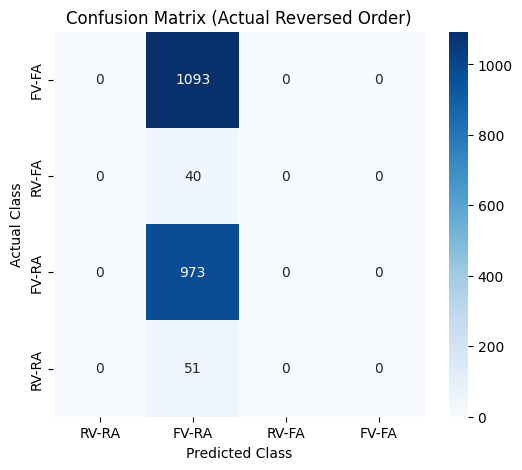


Classification Report:

              precision    recall  f1-score   support

       RV-RA       0.00      0.00      0.00      1093
       FV-RA       0.45      1.00      0.62       973
       RV-FA       0.00      0.00      0.00        40
       FV-FA       0.00      0.00      0.00        51

    accuracy                           0.45      2157
   macro avg       0.11      0.25      0.16      2157
weighted avg       0.20      0.45      0.28      2157



D:\Software\Anaconda3\envs\deepfake\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Software\Anaconda3\envs\deepfake\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Software\Anaconda3\envs\deepfake\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert numeric labels to names
class_names = ["RV-RA", "FV-RA", "RV-FA", "FV-FA"]

y_true_names = [class_names[i] for i in all_labels]
y_pred_names = [class_names[i] for i in all_preds]

# Reverse only ACTUAL labels
actual_labels_rev = list(reversed(class_names))

# Confusion Matrix
cm = confusion_matrix(y_true_names, y_pred_names, labels=class_names)

# Reorder rows (only actual/reality reversed)
row_indices = [class_names.index(lbl) for lbl in actual_labels_rev]
cm_reordered = cm[row_indices, :]

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_reordered, annot=True, fmt="d", cmap="Blues",
    xticklabels=class_names,           # Predicted normal order
    yticklabels=actual_labels_rev      # Actual reversed
)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix (Actual Reversed Order)")
plt.show()

# Classification Report (normal order)
print("\nClassification Report:\n")
print(classification_report(y_true_names, y_pred_names, target_names=class_names))
